# Flight Predicter



## Setup

In [46]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config('spark.ui.port', '4040') \
    .getOrCreate()


In [47]:

df = spark.read.csv('hdfs://localhost:9000/user/flight_data/flights.csv', header=True, inferSchema=True)
df.printSchema()
df.describe().show()



root
 |-- id: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dep_time: double (nullable = true)
 |-- sched_dep_time: integer (nullable = true)
 |-- dep_delay: double (nullable = true)
 |-- arr_time: double (nullable = true)
 |-- sched_arr_time: integer (nullable = true)
 |-- arr_delay: double (nullable = true)
 |-- carrier: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- air_time: double (nullable = true)
 |-- distance: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- time_hour: string (nullable = true)
 |-- name: string (nullable = true)



+-------+-----------------+------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-------+------------------+-------+------+------+------------------+------------------+------------------+------------------+-------------------+--------------------+
|summary|               id|  year|             month|              day|          dep_time|    sched_dep_time|         dep_delay|          arr_time|   sched_arr_time|        arr_delay|carrier|            flight|tailnum|origin|  dest|          air_time|          distance|              hour|            minute|          time_hour|                name|
+-------+-----------------+------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-------+------------------+-------+------+------+------------------+------------------+------------------+-----------

In [48]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="carrier", outputCol="carrier_index")
df = indexer.fit(df).transform(df)


In [49]:
df.show()

+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+--------------------+-------------+
| id|year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|          time_hour|                name|carrier_index|
+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+--------------------+-------------+
|  0|2013|    1|  1|   517.0|           515|      2.0|   830.0|           819|     11.0|     UA|  1545| N14228|   EWR| IAH|   227.0|    1400|   5|    15|2013-01-01 05:00:00|United Air Lines ...|          0.0|
|  1|2013|    1|  1|   533.0|           529|      4.0|   850.0|           830|     20.0|     UA|  1714| N24211|   LGA| IAH|   227.0|    1416|   5|    29|2013-01-01 

## Preprocessing

The below code block is the preprocessing of handling null values, particularly arr_delay. If any entry does not have a value for arr_delay, it will be calculated for using the other provided values such as arr_time and sched_arr_time. If there is no combination of data that can result in an arr_delay value, the entry will be dropped as an estimation would require too many calculations specific to that entry. 

In [51]:
from pyspark.sql.functions import col, when

df_test = df.withColumn(
    'arr_delay',
    when(
        col('arr_delay').isNull() & col('arr_time').isNotNull() & col('sched_arr_time').isNotNull(),
        col('arr_time') - col('sched_arr_time')
    ).when(
        col('arr_delay').isNull() & col('dep_time').isNotNull() & col('air_time').isNotNull() & col('sched_arr_time').isNotNull(),
        (
            col('dep_time') + col('air_time') - col('sched_arr_time') +
            when(col('day') < col('sched_arr_time'), 240).otherwise(0)
        )
    ).otherwise(col('arr_delay'))  
)


df_test = df_test.withColumn(
    "air_time",
    when(
        col("air_time").isNull() & col("arr_time").isNotNull() & col("dep_time").isNotNull(),
        (col("arr_time") - col("dep_time")) + when(col('arr_time') < col('dep_time'), 240).otherwise(0)  
    ).otherwise(col("air_time"))
)

df_test = df_test.withColumn("delayed", (df_test["arr_delay"] > 15).cast("integer"))


df_test.show(truncate=False)


+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+------------------------+-------------+-------+
|id |year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|time_hour          |name                    |carrier_index|delayed|
+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+------------------------+-------------+-------+
|0  |2013|1    |1  |517.0   |515           |2.0      |830.0   |819           |11.0     |UA     |1545  |N14228 |EWR   |IAH |227.0   |1400    |5   |15    |2013-01-01 05:00:00|United Air Lines Inc.   |0.0          |0      |
|1  |2013|1    |1  |533.0   |529           |4.0      |850.0   |830           |20.0     |UA     |1714  |N24211 |LGA  

In [52]:
row_with_id_733_fixed = df_test.filter(col("id") == 733)
row_with_id_733 = df.filter(col("id") == 733)

row_with_id_733.show(truncate=False)

row_with_id_733_fixed.show(truncate=False)


+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+------------------------+-------------+
|id |year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|time_hour          |name                    |carrier_index|
+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+------------------------+-------------+
|733|2013|1    |1  |1952.0  |1930          |22.0     |2358.0  |2207          |null     |EV     |4333  |N11194 |EWR   |TUL |null    |1215    |19  |30    |2013-01-01 19:00:00|ExpressJet Airlines Inc.|2.0          |
+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+--

In [53]:
columns_to_check = [ 'arr_time', 'arr_delay']

# Drop rows with null values in the specified columns
data_preprocessed = df_test.dropna(subset=columns_to_check)



In [56]:
from pyspark.sql.functions import col, isnan
from functools import reduce

missing_rows = data_preprocessed.filter(
    reduce(lambda a, b: a | b, [col(c).isNull() | isnan(c) for c in df.columns])
)

# Show all rows with missing values
missing_rows.show(truncate=False)


+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+---------+----+-------------+-------+
|id |year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|time_hour|name|carrier_index|delayed|
+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+---------+----+-------------+-------+
+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+---------+----+-------------+-------+



In [57]:
data_preprocessed.show(5)

+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+--------------------+-------------+-------+
| id|year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|          time_hour|                name|carrier_index|delayed|
+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+--------------------+-------------+-------+
|  0|2013|    1|  1|   517.0|           515|      2.0|   830.0|           819|     11.0|     UA|  1545| N14228|   EWR| IAH|   227.0|    1400|   5|    15|2013-01-01 05:00:00|United Air Lines ...|          0.0|      0|
|  1|2013|    1|  1|   533.0|           529|      4.0|   850.0|           830|     20.0|     UA|  1714| N24211|   LGA| IAH|   227.0|

## Data Visualisation

In [66]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

df_categorized = data_preprocessed.withColumn(
    "delay_category",
    when(col("arr_delay") <= 0, "On time")
    .when((col("arr_delay") > 0) & (col("arr_delay") <= 15), "Short delay")
    .when((col("arr_delay") > 15) & (col("arr_delay") <= 60), "Moderate delay")
    .when(col("arr_delay") > 60, "Long delay")
    .otherwise("Unknown")  
)




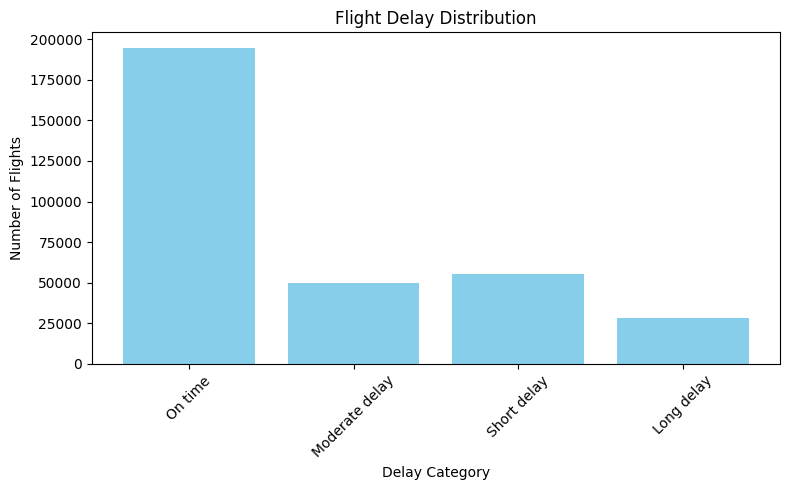

In [67]:
delay_distribution = df_categorized.groupBy("delay_category").count().collect()
categories = [row["delay_category"] for row in delay_distribution]
counts = [row["count"] for row in delay_distribution]

plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color='skyblue')
plt.title("Flight Delay Distribution")
plt.xlabel("Delay Category")
plt.ylabel("Number of Flights")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## modellering och träning

In [ ]:
#NOT DONE
train_data, validation_data, test_data = data_preprocessed.randomSplit([0.3, 0.4, 0.3], seed=42)
